2D Classical Ising Model NLCE Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

Old hardcoded approach where multiplicities, bonds, coordinates are solved by hand up to order 4

In [ ]:
# # First we want to get the multiplicites for each order and each cluster
# # multiplicites[1] returns the multiplicities of different clusters in order 1, etc. (Note for order 1,2 there is only one cluster)
# # really these should be dynamically calculated so we can go to higher orders, but I just solved these by hand.
# # Not sustainable for larger orders lol

# multiplicites = {}
# multiplicites[1] = [1] # (0,0)
# multiplicites[2] = [2] # ((0,0), (1,0)) or ((0,0), (0,1))
# multiplicites[3] = [2,4] # [((0,0), (1,0), (2,0) or (0,0), (0,1), (0,2)];
#                          #  ((0,0), (0,1), (1,1) or (0,0), (1,0), (1,1) or (0,0),(0,1),(-1,1) or ((0,0),(-1,0),(-1,1))]
# multiplicites[4] = [2,8,4,4,1] # Too long to write out sorry

# bonds = {
#     1: [],

#     2: [((0, 0), (1, 0))],

#     3: [[((0, 0), (1, 0)), ((1, 0), (2, 0))],  # three in a line
#         [((0, 0), (1, 0)), ((1, 0), (1, 1))]], # L shape

#     4: [[((0, 0), (1, 0)), ((1, 0), (2, 0)), ((2, 0), (3, 0))], # four in a line
#         [((0,0), (1,0)), ((1,0), (2,0)), ((2,0), (2,1))], # L shape
#         [((0,0), (1,0)), ((1,0), (1,1)), ((1,1),(2,1))], # Z shape
#         [((0,0), (1,0)), ((1,0), (1,1)), ((1,0),(2,0))], # T shape
#         [((0,0), (1,0)), ((1,0), (1,1)), ((1,1),(0,1)), ((0,1),(0,0))]] # square
# }

# coordinates = {
#     1: [(0, 0)], # single site

#     2: [(0, 0), (1, 0)], # two sites in a line

#     3: [[(0,0), (1,0), (2,0)], # three in a line
#         [(0,0), (1,0), (1,1)]], # L shape
        
#     4: [[(0, 0), (1, 0), (2, 0), (3, 0)], # four in a line
#         [(0,0), (1,0), (2,0), (2,1)], # three in a line with one off to the side
#         [(0,0), (1,0), (1,1), (2,1)], # z shape
#         [(0,0), (1,0), (1,1), (2,0)], # T shape
#         [(0,0), (1,0), (1,1), (0,1)]], # square
# }

# Temps = np.linspace(0.1, 10.0, 100)
# orders = [1,2,3,4]
# J = 1

In [2]:
def generate_spin_configurations(order):
    # we want to generate a matrix as follows
    # shape (1,2**order) with each row is a list of order spins.
    # each row is a different spin configuration
    # each column is a different spin configuration
    # e.g. for order 3
    # [[1,1,1],
    #  [1,1,-1],
    #  [1,-1,1],
    #  [1,-1,-1],
    #  [-1,1,1],
    #  [-1,1,-1],
    #  [-1,-1,1],
    #  [-1,-1,-1]]
    num_configs = 2**order
    configurations = np.zeros((num_configs, order), dtype=int)
    for i in range(num_configs):
        for j in range(order):
            if (i // (2**j)) % 2 == 0:
                configurations[i, j] = 1
            else:
                configurations[i, j] = -1
    return configurations

In [ ]:
def calculate_cluster_info(beta, J, cluster_bonds):
    # calculates the partition function and energy for a given cluster
    if not cluster_bonds: # empty list, no bonds
        return 2.0, 0.0
    

    sites = set()
    for bond in cluster_bonds:
        sites.add(bond[0])
        sites.add(bond[1])
    
    site_list = sorted(list(sites))
    site_to_index = {site: i for i, site in enumerate(site_list)}
    num_sites = len(site_list)

    configurations = generate_spin_configurations(num_sites)
    
    # Calculate partition function and energy
    Z = 0.0
    E_sum = 0.0
    for config in configurations:
        energy_coeff = 0
        for bond in cluster_bonds:
            i = site_to_index[bond[0]]
            j = site_to_index[bond[1]]
            energy_coeff += config[i] * config[j]
        
        boltzmann_factor = np.exp(J * beta * energy_coeff)
        Z += boltzmann_factor
        E_sum += energy_coeff * boltzmann_factor
    
    # Calculate average energy
    E = -J * E_sum / Z
    
    return Z, E

In [ ]:
def normalize_cluster(sites):
        # normalizes the clusters so they can be compared against other clusters for symmetrical distinction
        sites = sorted(sites)
        min_site = sites[0]
        normalized = [(x - min_site[0], y - min_site[1]) for x, y in sites]
        return tuple(sorted(normalized))

def get_canonical_form(sites):
        # checks for symmetrically indistinct versions of the cluster
        canonical_forms = set()
        
        # original cluster
        canonical_forms.add(normalize_cluster(sites))
        
        # 90 degree rotation
        rotated_90 = [(-y, x) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_90))

        # 180 degree rotation
        rotated_180 = [(-x, -y) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_180))

        # 270 degree rotation
        rotated_270 = [(y, -x) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_270))
        
        # reflection across x axis
        reflected_x = [(x, -y) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_x))

        # reflection across y axis
        reflected_y = [(-x, y) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_y))

        # reflection across y=x
        reflected_diag = [(y, x) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_diag))

        # reflection across y=-x
        reflected_antidiag = [(-y, -x) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_antidiag))
        
        # return minimized cluster
        return min(canonical_forms)

def calculate_multiplicity(sites):
        # calculates the multiplicity of a specific cluster

        canonical = normalize_cluster(sites)
        
        # count how many symmetry operations leave the cluster unchanged
        identical_count = 0
        
        transformations = [
            lambda x, y: (x, y),           # identity
            lambda x, y: (-y, x),          # 90 degree rotation
            lambda x, y: (-x, -y),         # 180 degree rotation
            lambda x, y: (y, -x),          # 270 degree rotation
            lambda x, y: (x, -y),          # reflection x axis
            lambda x, y: (-x, y),          # reflection y axis
            lambda x, y: (y, x),           # reflection y=x
            lambda x, y: (-y, -x),         # reflection y=-x
        ]
        
        for transform in transformations:
            transformed = [transform(x, y) for x, y in sites]
            if normalize_cluster(transformed) == canonical:
                identical_count += 1
        
        return 8 // identical_count

In [ ]:
def count_embeddings(large_cluster_coords, small_cluster_coords):
    # calculates the number of embeddings for each small cluster in a large cluster
    # e.g. checks how many times a specific order 3 cluster appears in an order 4 cluster
    
    if len(small_cluster_coords) > len(large_cluster_coords):
        return 0
    
    if len(small_cluster_coords) == len(large_cluster_coords):
        # Same size - check if they're the same cluster (up to symmetry)
        return 1 if get_canonical_form(large_cluster_coords) == get_canonical_form(small_cluster_coords) else 0
    
    # Get canonical form of the small cluster
    small_canonical = get_canonical_form(small_cluster_coords)
    count = 0
    
    # Check all subsets of the appropriate size in the large cluster
    for subset in combinations(large_cluster_coords, len(small_cluster_coords)):
        subset_canonical = get_canonical_form(list(subset))
        if subset_canonical == small_canonical:
            count += 1
    
    return count

def calculate_weights(beta, J, orders, bonds, coordinates):
    # calculates the weights for each cluster in each order

    weights = {}
    
    # Process each order sequentially
    for order in sorted(orders):
        weights[order] = []
        
        # Process each cluster in this order
        for cluster_idx in range(len(bonds[order])):
            # get energy of specific cluster
            Z, E_raw = calculate_cluster_info(beta, J, bonds[order][cluster_idx])
            
            # calculate weight by subtracting embedded subclusters
            weight = E_raw
            for sub_order in range(1, order):
                if sub_order not in weights:
                    continue
                    
                for sub_cluster_idx in range(len(coordinates[sub_order])):
                    # Count how many times this subcluster appears in current cluster
                    embedding_count = count_embeddings(
                        coordinates[order][cluster_idx],
                        coordinates[sub_order][sub_cluster_idx]
                    )
                    
                    if embedding_count > 0:
                        weight -= embedding_count * weights[sub_order][sub_cluster_idx]
            
            weights[order].append(weight)
    
    return weights

In [ ]:
def calculate_lattice_energy(beta, J, orders, multiplicities, bonds, coordinates):
    # computes the total energy of the lattice using weights, multiplicities, and clusters

    weights = calculate_weights(beta, J, orders, bonds, coordinates)

    lattice_energy = 0.0
    for order in orders:
        for idx, multiplicity in enumerate(multiplicities[order]):
            lattice_energy += multiplicity * weights[order][idx]

    return lattice_energy

In [ ]:
def generate_clusters(order):
    # start with order 1 cluster (0,0) and build up to the desired order by adding neighboring sites to each point in the cluster
    # this is pretty horribly inefficient, but at least it works.

    clusters = {}
    
    clusters[1] = [[(0,0)]]
    
    neighboring_sites = [(1,0),(-1,0),(0,1),(0,-1)]
    
    for cluster_ord in range(2, order + 1):
        clusters[cluster_ord] = []

        for prev_cluster in clusters[cluster_ord - 1]:
            prev_sites = set(prev_cluster)
            
            neighbor_candidates = set()
            for ci, cj in prev_cluster:
                for ni, nj in neighboring_sites:
                    new_site = (ci + ni, cj + nj)
                    if new_site not in prev_sites:
                        neighbor_candidates.add(new_site)
            
            for new_site in neighbor_candidates:
                new_cluster = prev_cluster + [new_site]
                clusters[cluster_ord].append(new_cluster)
    
    return clusters

def remove_duplicates(clusters):
    # removes symmetrically indistinct clusters and then calculates their multiplicities
    
    unique_clusters = {}
    multiplicities_dic = {}
    
    for order, cluster_list in clusters.items():
        unique_set = set()
        unique_list = []
        multiplicities = []
        
        for cluster in cluster_list:
            canonical = get_canonical_form(cluster)
            if canonical not in unique_set:
                unique_set.add(canonical)
                unique_list.append(cluster)

                multiplicity = calculate_multiplicity(cluster)
                multiplicities.append(multiplicity)
        multiplicities_dic[order] = multiplicities

        unique_clusters[order] = unique_list
    return unique_clusters, multiplicities_dic

def generate_bonds_from_clusters(clusters):
    # generate bonds for each cluster by connecting neighboring sites

    bonds = {}
    for order, cluster_list in clusters.items():
        bonds[order] = []
        for cluster in cluster_list:
            cluster_bonds = []
            site_set = set(cluster)
            for (x, y) in cluster:
                # Check right neighbor
                if (x + 1, y) in site_set:
                    cluster_bonds.append(((x, y), (x + 1, y)))
                # Check up neighbor
                if (x, y + 1) in site_set:
                    cluster_bonds.append(((x, y), (x, y + 1)))
            bonds[order].append(cluster_bonds)
    return bonds



Calculating energies for order 1...
Calculating energies for order 2...
Calculating energies for order 3...
Calculating energies for order 4...
Calculating energies for order 5...
Calculating energies for order 6...
Calculating energies for order 7...
Calculating energies for order 8...
Calculating energies for order 9...


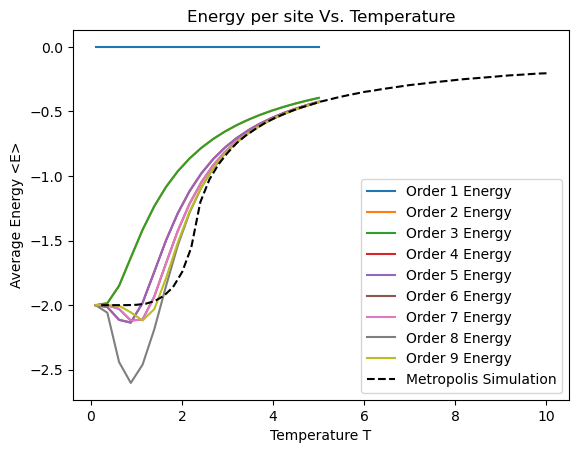

In [ ]:
energies = {}
orders = [1,2,3,4,5,6,7,8,9]
J = 1

# generate clusters and bonds up to our max order
clusters = generate_clusters(np.max(orders))
clusters, multiplicities = remove_duplicates(clusters)
bonds = generate_bonds_from_clusters(clusters)

# iterate over temperatures so we can plot against expected result
Temps = np.linspace(0.1,5,20)
for order in orders:
    energies[order] = []
    print(f"calculating order {order}")
    for T in Temps:
        beta = 1 / T
        weights = calculate_weights(beta, J, orders[:order], bonds, clusters)
        
        # # calculate the total lattice energy
        lattice_energy = 0.0
        for ord in range(1, order + 1):
            for idx, multiplicity in enumerate(multiplicities[ord]):
                lattice_energy += multiplicity * weights[ord][idx]
        
        energies[order].append(lattice_energy)

# plot results
for i in range(len(orders)):
    order = orders[i]
    plt.plot(Temps, energies[order], label=f'Order {order} Energy')

# load in monte carlo simulation results and plot for comparison    
metropolis = pd.read_csv("ising_metropolis_results.csv")
plt.plot(metropolis["T"], metropolis["Energy"], 'k--', label='Metropolis Simulation')
plt.xlabel('Temperature T')
plt.ylabel('Average Energy <E>')
plt.title("Energy per site Vs. Temperature")
plt.legend()
plt.show()

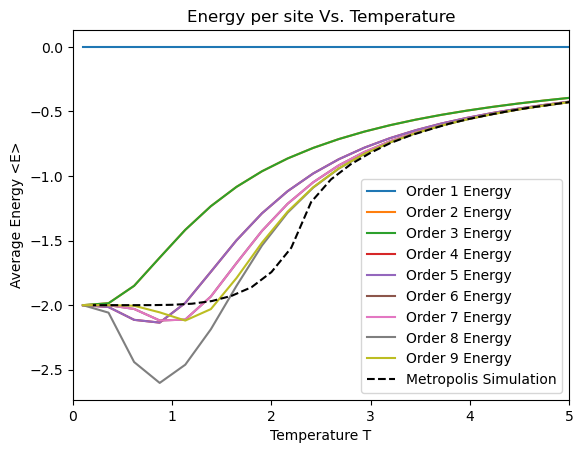

In [ ]:
# plot results
for i in range(len(orders)):
    order = orders[i]
    plt.plot(Temps, energies[order], label=f'Order {order} Energy')

plt.plot(metropolis["T"], metropolis["Energy"], 'k--', label='Metropolis Simulation')
plt.xlabel('Temperature T')
plt.ylabel('Average Energy <E>')
plt.xlim(0,5)
plt.title("Energy per site Vs. Temperature")
plt.legend()
plt.show()

Save Data

In [13]:
import json
file_path = "energies_o9.json"
with open(file_path, "w") as json_file:
    json.dump(energies, json_file, indent=4)

file_path = "clusters_o9.json"
with open(file_path, "w") as json_file:
    json.dump(clusters, json_file, indent=4)

file_path = "bonds_o9.json"
with open(file_path, "w") as json_file:
    json.dump(bonds, json_file, indent=4)

file_path = "multiplicities_o9.json"
with open(file_path, "w") as json_file:
    json.dump(multiplicities, json_file, indent=4)
